# Parallel Parking

[CFTOC problem formulation reference.](https://github.com/XiaojingGeorgeZhang/OBCA)

[Bicycle kinematic model reference.](https://dingyan89.medium.com/simple-understanding-of-kinematic-bicycle-model-81cac6420357)

## Dependencies

In [1]:
# install dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 3.1 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=1480303e029fea2039a01a5ae921170007651b741339efad96a12c6d5cace8c5
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 5.2 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

## Environment and Plotting Functions

In [2]:
# define environment generator
def environ_generator(model, x0, y0, theta0, xf, yf, thetaf,
                      car_width, car_height, 
                      parked_car_width, parked_car_height, 
                      world_width, world_height,
                      ax=None, plot=False):
  # define world parameters in model
  model.x_min = 0
  model.x_max = world_width

  model.y_min = 0
  model.y_max = world_height

  # define initial and final states of car in model
  model.x0 = x0
  model.y0 = y0
  model.theta0 = theta0

  model.xf = xf
  model.yf = yf
  model.thetaf = thetaf

  # generate polytope defining car
  p_car = pt.box2poly([[-car_width/2, car_width/2],
                       [-car_height/2, car_height/2]])
  
  model.G = p_car.A.reshape(4,2)
  model.g = p_car.b.reshape(4,1)

  # generate polytopes defining parked cars: left car is at bottom left corner 
  # of world and right car is at bottom right corner of world
  p_l_car = pt.box2poly([[0, parked_car_width],
                         [0, parked_car_height]])
  
  p_r_car = pt.box2poly([[world_width-parked_car_width, world_width],
                         [0, parked_car_height]])
  
  # polytope of sidewalk
  p_sw = pt.box2poly([[0, world_width],
                      [-3,0]])
  
  if plot:
    # plot cars
    p_l_car.plot(ax, color='r', alpha=0.7, linestyle='solid')
    p_r_car.plot(ax, color='r', alpha=0.7, linestyle='solid')
    p_sw.plot(ax, color='0.8', alpha=0.7, linestyle='solid')

    # plot box for world
    ax.add_patch(plt.Rectangle((model.x_min, model.y_min), 
                              model.x_max-model.x_min, model.y_max-model.y_min, 
                              color='g', fill=False, linestyle='--', 
                              linewidth=1.5))
  
  # define H-representation matrices of car obstacles and sidewalk in model
  model.A_l = p_l_car.A.reshape(4,2)
  model.b_l = p_l_car.b.reshape(4,1)
  model.A_r = p_r_car.A.reshape(4,2)
  model.b_r = p_r_car.b.reshape(4,1)
  model.A_sw = p_sw.A.reshape(4,2)
  model.b_sw = p_sw.b.reshape(4,1)

  model.A_obs = [model.A_l, model.A_r, model.A_sw]
  model.b_obs = [model.b_l, model.b_r, model.b_sw]

  return  

# define trajectory plotter
def traj_plotter(xopt, yopt, thetaopt, car_width, car_height, step, ax):
  # plot trajectory
  ax.plot(xopt, yopt, marker='o')

  # plot box for car geometry
  for idx in range(0, len(xopt), step):
    car_plotter(xopt[idx], yopt[idx], thetaopt[idx], car_width, car_height, ax)

  return

# define car plotter
def car_plotter(x_center, y_center, theta_rad, car_width, car_height, ax):
  # define transform
  t = Affine2D().rotate_deg_around(*(x_center, y_center), 
                                   np.rad2deg(theta_rad))+ax.transData

  # define rectangle
  rec = plt.Rectangle((x_center-car_width/2, y_center-car_height/2), 
                      width=car_width, height=car_height, transform=t,
                      alpha=0.2, linestyle='-', linewidth=1, edgecolor='b')
  
  # add to plot
  ax.add_patch(rec)

  # add green arrow to front
  x_dot = x_center+(car_width/2)*np.cos(theta_rad)
  y_dot = y_center+(car_width/2)*np.sin(theta_rad)
  ax.plot(x_dot, y_dot, marker='o', markersize=10, fillstyle='none', color='g')

  return

## Objective Rule Function

In [3]:
# define objective rule for minimization
def obj_rule(model):
  # define weighting factors
  q_time = 1
  r_delta = 1
  r_a = 3

  # initialize input stage cost and compute
  input_cost = 0.0
  for k in model.kidx:
    input_cost += r_delta*model.delta[k]**2 + r_a*model.a[k]**2

  # compute time cost
  time_cost = q_time*model.N*model.Ts

  # compute totol cost
  cost = time_cost + input_cost

  return cost

## System Kinematic Constraint Rule Functions

In [4]:
# define system kinematic constraint rules
def x_rule(model, k):
  beta = atan(model.wb/2 * tan(model.delta[k]) / model.wb)

  return (model.x[k+1] == (model.x[k] + model.Ts*cos(model.theta[k] + beta)
          *model.v[k]) if k < model.N else Constraint.Skip)

def y_rule(model, k):
  beta = atan(model.wb/2 * tan(model.delta[k]) / model.wb)

  return (model.y[k+1] == (model.y[k] + model.Ts*sin(model.theta[k] + beta)
          *model.v[k]) if k < model.N else Constraint.Skip)
  
def theta_rule(model, k):
  beta = atan(model.wb/2 * tan(model.delta[k]) / model.wb)

  return (model.theta[k+1] == (model.theta[k] + 
                               model.Ts*model.v[k]*tan(model.delta[k])*cos(beta)
                               /model.wb)
          if k < model.N else Constraint.Skip)
  
def v_rule(model, k):
  return (model.v[k+1] == (model.v[k] + model.Ts*model.a[k])
          if k < model.N else Constraint.Skip)

## Collision Constraint Rule Functions

In [5]:
# define collision constraint rules
def ineq_rule(model, k, o):
  # define A, b
  A = model.A_obs[o]
  b = model.b_obs[o]

  # define translated position from initial state
  xt = model.x[k]
  yt = model.y[k]

  return (sum(-model.g[l,0] * model.mu[k,o,l] + 
             (A[l,0]*xt + A[l,1]*yt - b[l,0]) * model.lamb[k,o,l] 
             for l in model.lidx ) >= model.d_min)

def eq_rule1(model, k, o):
  # define A, b
  A = model.A_obs[o]
  b = model.b_obs[o]

  # define rotation matrix
  theta = model.theta[k]
  R = np.array([[cos(theta), -sin(theta)],
                [sin(theta), cos(theta)]])
  
  return (sum( model.G[l,0]*model.mu[k,o,l] + 
              R[0,0]*A[l,0]*model.lamb[k,o,l] + 
              R[1,0]*A[l,1]*model.lamb[k,o,l] 
              for l in model.lidx ) == 0)
  
def eq_rule2(model, k, o):
  # define A, b
  A = model.A_obs[o]
  b = model.b_obs[o]

  # define rotation matrix
  theta = model.theta[k]
  R = np.array([[cos(theta), -sin(theta)],
                [sin(theta), cos(theta)]])

  return (sum( model.G[l,1]*model.mu[k,o,l] + 
              R[0,1]*A[l,0]*model.lamb[k,o,l] + 
              R[1,1]*A[l,1]*model.lamb[k,o,l] 
              for l in model.lidx ) == 0)

def norm_rule(model, k, o):
  # define A and lamb
  A = model.A_obs[o]

  return (sum( A[l,0]*model.lamb[k,o,l] for l in model.lidx )**2 + 
          sum( A[l,1]*model.lamb[k,o,l] for l in model.lidx )**2) <= 1

def lamb_rule(model, k, o, l):
  return model.lamb[k,o,l] >= 0

def mu_rule(model, k, o, l):
  return model.mu[k,o,l] >= 0

## CFTOC Solver Function

In [6]:
def solve_cftoc(N, delta_max, a_max, d_min, Ts_min, Ts_max,
                x0, y0, theta0, v0, xf, yf, thetaf, vf,
                car_width, car_height, car_wheelbase,
                parked_car_width, parked_car_height,
                world_width, world_height,
                ax=None, plot=False):
  # create model, define horizon
  model = ConcreteModel()
  model.N = N

  # define problem parameters in model
  model.v0 = v0
  model.vf = vf
  model.wb = car_wheelbase
  model.d_min = d_min

  # generate environment in model
  environ_generator(model, x0, y0, theta0, xf, yf, thetaf,
                    car_width, car_height, 
                    parked_car_width, parked_car_height,
                    world_width, world_height,
                    ax, plot)
  if plot:
    # make aspect equal
    ax.set_aspect('equal', adjustable='box')

  # define indices for horizon
  model.kidx = Set(initialize=range(model.N+1), ordered=True)

  # define obstacle indices
  model.oidx = Set(initialize=range(len(model.A_obs)), ordered=True) # number of obstacles
  model.lidx = Set(initialize=range(4), ordered=True) # number of half-spaces per obstacle

  # create variable for sampling time
  model.Ts = Var(initialize=Ts_min, bounds=(Ts_min, Ts_max))

  # create state variable trajectories with constraints
  xinit = np.linspace(model.x0, model.xf, N+1)
  yinit = np.linspace(model.y0, model.yf, N+1)

  model.x = Var(model.kidx, initialize=xinit, bounds=(model.x_min,model.x_max)) # x-position
  model.y = Var(model.kidx, initialize=yinit, bounds=(model.y_min,model.y_max)) # y-position
  model.theta = Var(model.kidx) # angle
  model.v = Var(model.kidx) # velocity

  # create input variable trajectories with constraints
  model.delta = Var(model.kidx, bounds=(-delta_max, delta_max)) # input steering angle in radians
  model.a = Var(model.kidx, bounds=(-a_max, a_max)) # input acceleration

  # create dual variable trajectories with constraints: left car oidx=0, right
  # car oidx=1
  model.lamb = Var(model.kidx, model.oidx, model.lidx)
  model.mu = Var(model.kidx, model.oidx, model.lidx)

  # define initial and final state constraints
  model.x0_const = Constraint(expr=(model.x[0]==model.x0))
  model.y0_const = Constraint(expr=(model.y[0]==model.y0))
  model.theta0_const = Constraint(expr=(model.theta[0]==model.theta0))
  model.v0_const = Constraint(expr=(model.v[0]==model.v0))

  model.xf_const = Constraint(expr=(model.x[model.N]==model.xf))
  model.yf_const = Constraint(expr=(model.y[model.N]==model.yf))
  model.thetaf_const = Constraint(expr=(model.theta[model.N]==model.thetaf))
  model.vf_const = Constraint(expr=(model.v[model.N]==model.vf))

  # define system kinematic constraints
  model.x_kin_const = Constraint(model.kidx, rule=x_rule)
  model.y_kin_const = Constraint(model.kidx, rule=y_rule)
  model.theta_kin_const = Constraint(model.kidx, rule=theta_rule)
  model.v_kin_const = Constraint(model.kidx, rule=v_rule)

  # define collision constraints
  model.ineq_const = Constraint(model.kidx, model.oidx, rule=ineq_rule)
  model.eq1_const = Constraint(model.kidx, model.oidx, rule=eq_rule1)
  model.eq2_const = Constraint(model.kidx, model.oidx, rule=eq_rule2)
  model.norm_const = Constraint(model.kidx, model.oidx, rule=norm_rule)
  model.lamb_const = Constraint(model.kidx, model.oidx, model.lidx, rule=lamb_rule)
  model.mu_const = Constraint(model.kidx, model.oidx, model.lidx, rule=mu_rule)

  # define objective function
  model.obj = Objective(rule=obj_rule, sense=minimize)

  # solve
  solver = SolverFactory('ipopt', executable='/content/ipopt')
  results = solver.solve(model)
  print('IPOPT Solver Status: ' + str(results.solver.termination_condition))

  # parse solution
  xopt = np.asarray([model.x[i]() for i in model.kidx])
  yopt = np.asarray([model.y[i]() for i in model.kidx])
  thetaopt = np.asarray([model.theta[i]() for i in model.kidx])
  vopt = np.asarray([model.v[i]() for i in model.kidx])
  deltaopt = np.asarray([model.delta[i]() for i in model.kidx])
  aopt = np.asarray([model.a[i]() for i in model.kidx])
  Tsopt = model.Ts()

  if plot:
    # plot trajectory
    step = 8
    traj_plotter(xopt, yopt, thetaopt, car_width, car_height, step, ax)

  return xopt, yopt, thetaopt, vopt, deltaopt, aopt, Tsopt

## Main Script
### CFTOC

In [7]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import polytope as pt
from pyomo.environ import *
from matplotlib.transforms import Affine2D

IPOPT Solver Status: optimal
Optimal Time Step: 0.26960965259965125
Total Control Time: 26.960965259965125


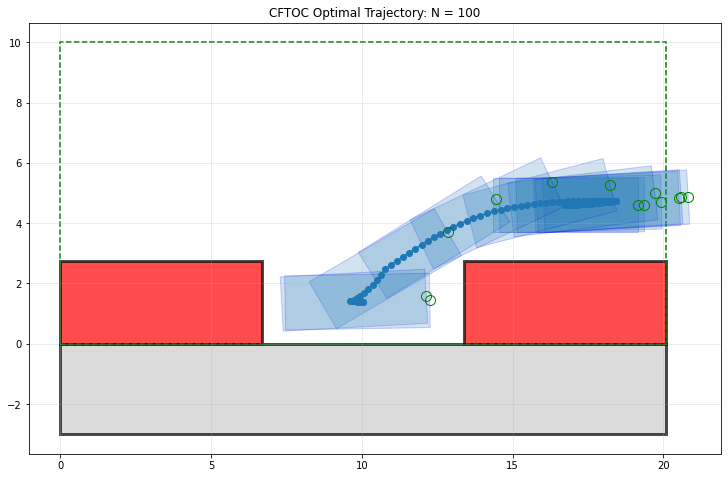

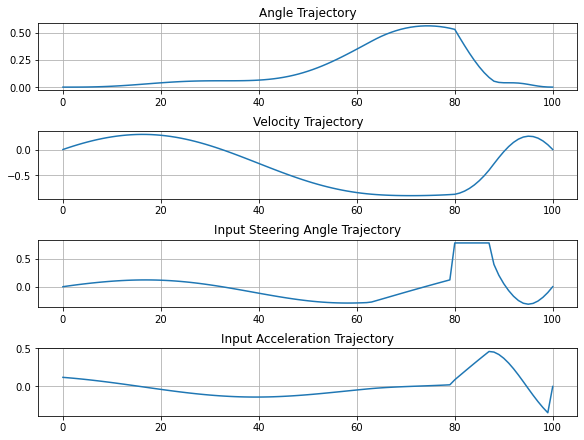

In [8]:
### DEFINE PROBLEM PARAMETERS ###

'''
 - all dimensions, parameters, etc in SI units 
 - for reverse case: (x0, y0) = (16.75, 4.6) or something close
 - for forward case: (x0, y0) = (3.35, 4.6) or something close
'''

N = 100 # horizon
delta_max = np.deg2rad(45) # maximum input steering angle
a_max = 4 # maximum input acceleration
d_min = 0.2 # minimum distance of car to obstacles

Ts_min = 0.01 # minimum time step
Ts_max = 0.5 # maximum time step

# initial state (center of car)
x0 = 16.75
y0 = 4.6
theta0 = 0
v0 = 0

# final state (center of car)
xf = 10.05
yf = 1.375
thetaf = 0
vf = 0

# dimensions: toyota camry, 9' x 22' foot spot in meters
car_width = 4.8
car_height = 1.8

parked_car_width = 6.7
parked_car_height = 2.75

world_width = 20.1
world_height = 10

car_wheelbase = 2.8

### SOLVE CFTOC ###

# define axes for trajectory plot
fig1, ax_traj = plt.subplots(figsize=(10,10), constrained_layout=True)

xopt, yopt, thetaopt, vopt, deltaopt, aopt, Tsopt = solve_cftoc(
                N, delta_max, a_max, d_min, Ts_min, Ts_max,
                x0, y0, theta0, v0, xf, yf, thetaf, vf,
                car_width, car_height, car_wheelbase,
                parked_car_width, parked_car_height,
                world_width, world_height,
                ax_traj, True)

ax_traj.set_title('CFTOC Optimal Trajectory: N = '+str(N))
ax_traj.grid(alpha=0.3)

# make aspect equal
ax_traj.set_aspect('equal', adjustable='box')

### PLOT TRAJECTORIES ###

fig2, ax = plt.subplots(4,1, figsize=(8,6), 
                        constrained_layout=True)

ax[0].plot(thetaopt)
ax[0].set_title('Angle Trajectory')
ax[0].grid()

ax[1].plot(vopt)
ax[1].set_title('Velocity Trajectory')
ax[1].grid()

ax[2].plot(deltaopt)
ax[2].set_title('Input Steering Angle Trajectory')
ax[2].grid()

ax[3].plot(aopt)
ax[3].set_title('Input Acceleration Trajectory')
ax[3].grid()

print('Optimal Time Step: ' + str(Tsopt))
print('Total Control Time: ' + str(Tsopt*N))

### MPC

In [9]:
### DEFINE MPC PARAMETERS ###

M = 50 # number of simulations
N = 20 # CFTOC horizon

Ts_min = 0.01
Ts_max = 0.5

# storage lists
xopt_list = []
yopt_list = []
thetaopt_list = []
vopt_list = []
deltaopt_list = []
aopt_list = []
Tsopt_list = []

# compute CFTOC's
for m in range(M):
  # run CFTOC
  xopt, yopt, thetaopt, vopt, deltaopt, aopt, Tsopt = solve_cftoc(
                N, delta_max, a_max, d_min, Ts_min, Ts_max,
                x0, y0, theta0, v0, xf, yf, thetaf, vf,
                car_width, car_height, car_wheelbase,
                parked_car_width, parked_car_height,
                world_width, world_height)
  
  # update next initial state
  x0 = xopt[1]
  y0 = yopt[1]
  theta0 = thetaopt[1]
  v0 = vopt[1]

  # append to lists
  xopt_list.append(xopt)
  yopt_list.append(yopt)
  thetaopt_list.append(thetaopt)
  vopt_list.append(vopt)
  deltaopt_list.append(deltaopt)
  aopt_list.append(aopt)
  Tsopt_list.append(Tsopt)

IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver Status: optimal
IPOPT Solver S

Total Control Time: 17.873594814424763


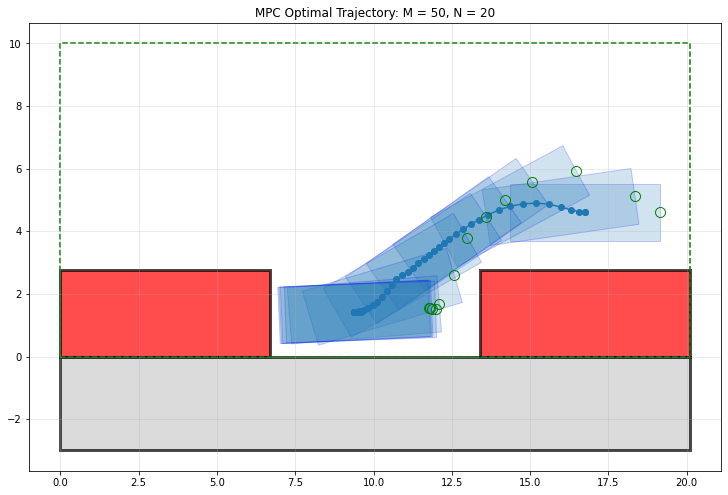

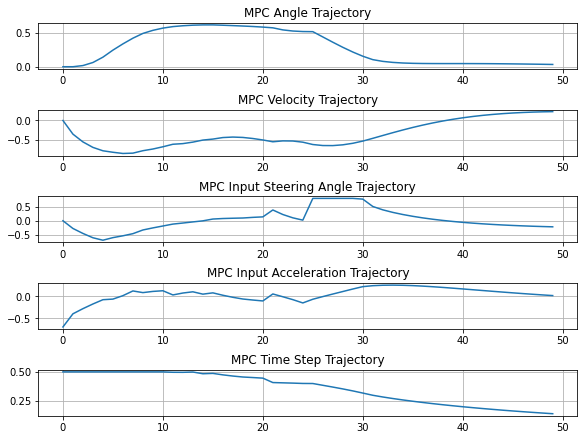

In [10]:
# parse for closed loop trajectory
xcl = []
ycl = []
thetacl = []
vcl = []
deltacl = []
acl = []
for idx in range(len(xopt_list)):
  xcl.append(xopt_list[idx][0])
  ycl.append(yopt_list[idx][0])
  thetacl.append(thetaopt_list[idx][0])
  vcl.append(vopt_list[idx][0])
  deltacl.append(deltaopt_list[idx][0])
  acl.append(aopt_list[idx][0])

# plot environment
fig3, ax_mpc = plt.subplots(figsize=(10,10), constrained_layout=True)

m = ConcreteModel() # ignore this model, just using to run environ_generator
environ_generator(m, x0, y0, theta0, xf, yf, thetaf,
                      car_width, car_height, 
                      parked_car_width, parked_car_height, 
                      world_width, world_height,
                      ax_mpc, True)

traj_plotter(xcl, ycl, thetacl, car_width, car_height, 4, ax_mpc)
ax_mpc.set_title('MPC Optimal Trajectory: M = '+str(M)+', N = '+str(N))
ax_mpc.grid(alpha=0.3)

# make aspect equal
ax_mpc.set_aspect('equal', adjustable='box')

### PLOT TRAJECTORIES ###

fig4, ax2 = plt.subplots(5,1, figsize=(8,6), 
                        constrained_layout=True)

ax2[0].plot(thetacl)
ax2[0].set_title('MPC Angle Trajectory')
ax2[0].grid()

ax2[1].plot(vcl)
ax2[1].set_title('MPC Velocity Trajectory')
ax2[1].grid()

ax2[2].plot(deltacl)
ax2[2].set_title('MPC Input Steering Angle Trajectory')
ax2[2].grid()

ax2[3].plot(acl)
ax2[3].set_title('MPC Input Acceleration Trajectory')
ax2[3].grid()

ax2[4].plot(Tsopt_list)
ax2[4].set_title('MPC Time Step Trajectory')
ax2[4].grid()

print('Total Control Time: ' + str(sum(Tsopt_list)))